## Iterative solution of an elliptic eqn

* Take the following equation
$$
-\nabla^2 \phi = q \;\; q = 2(2-x^2 - y^2)
$$
* with boundary conditions
$$
\phi(\pm 1, y) = 0, \;\; \phi(x, \pm 1)=0
$$

* Spatial derivatives are calculated with second-order central differences, as used in the course $(\Delta x =\Delta y = \Delta)$.
$$
\dfrac{\phi_{i+1,j} -2\phi_{i,j} + \phi_{i-1,j}}{\Delta^2} + \dfrac{\phi_{i,j+1} -2\phi_{i,j} + \phi_{i,j-1}}{\Delta^2} = q_{i,j}
$$

#### Libraries

In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pylab as plt

import time as time

from mpl_toolkits import mplot3d

import os, sys
sys.path.append('src')
from Poisson_solve import *

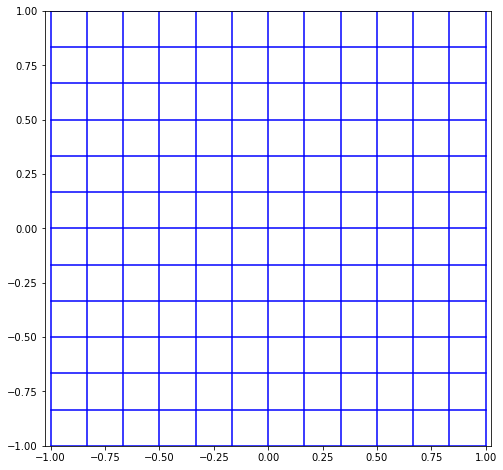

In [2]:
# Mesh

n    = 13  
m    = 13  # grid aspect ratio of 1 -> m=n

x    = np.linspace(-1, 1, num = n) 
y    = np.linspace(-1, 1, num = m)

delta= 2/(n-1)

# -----------------------------------

plt.figure(figsize=(8,8))

X, Y = np.meshgrid(x, y)

plt.plot(X, Y, 'b-')
plt.plot(X.T, Y.T, 'b-')

plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

### Exact solution

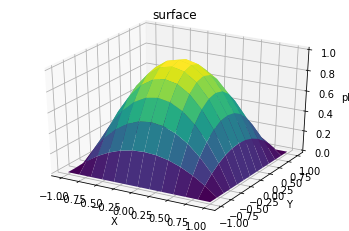

In [3]:
phi_exact = (X**2 - 1)*(Y**2 - 1)

ax  = plt.axes(projection='3d')

ax.plot_surface(X, Y, phi_exact, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('phi')

plt.show()

### Initial condition

In [4]:
s     = (n,m)
phi_0 = np.zeros(s)

### Evaluate right-hand-side

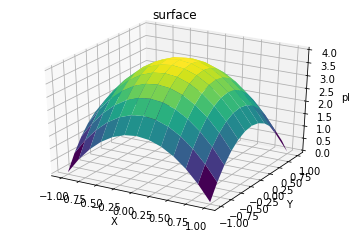

In [5]:
q = 2*(2 - X**2 - Y**2)

ax  = plt.axes(projection='3d')

ax.plot_surface(X, Y, q, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('phi')

plt.show()

## TP3

In [6]:
# point Jacobi 

def Jacobi(phi0, q, n, m, delta):
    
    """ Jacobian method """
        
    # Initial    
    #u = np.zeros((n, m))
    phi = phi0.copy()

    for i in range(1,n-1):
        for j in range(1,m-1):
            phi[i,j] = .25*(phi0[i-1,j] + phi0[i+1,j] + phi0[i,j-1] + phi0[i,j+1]) + ((delta**2)/4)*q[i,j]
            
    return phi
    
# GS

def GS(phi0, q, n, m, delta):
     
    """ GS method """
       
    # Initial    
    #u = np.zeros((n, m))
    phi = phi0.copy()
    
    for i in range(1,n-1):
        for j in range(1,m-1):
            phi[i,j] = .25*(phi[i-1,j] + phi0[i+1,j] + phi[i,j-1] + phi0[i,j+1]) + ((delta**2)/4)*q[i,j]
        
    return phi

# SOR

def SOR(phi0, q, n, m, delta, omega):

    """ SOR method """

    phi    = phi0.copy()
    phi_SOR = phi0.copy()
    
    for i in range(1,n-1):
        for j in range(1,m-1):
            phi_SOR[i,j] = .25*(phi[i-1,j] + phi[i+1,j] + phi[i,j-1] + phi[i,j+1]) + ((delta**2)/4)*q[i,j]
            phi[i,j]    = phi[i,j] + omega*(phi_SOR[i,j] - phi[i,j])
    
    return phi

In [7]:
phi           = phi_0
error         = np.sum(np.abs(phi - phi_exact))/np.sum(phi_exact)

kmax          = 5*10**3
counter       = 0

omega         = 1.7

# ----------------------------

t0            = time.time()

while error > 10**-6:
    #phi_temp   = Jacobi(phi, q, n, m, delta)
    #phi_temp  = GS(phi, q, n, m, delta)
    phi_temp  = SOR(phi, q, n, m, delta, omega)

    error     = np.sum(np.abs(phi_temp - phi_exact))/np.sum(phi_exact)

    counter   += 1
    phi       = phi_temp

tf            = time.time()

calc_time_TP3 = tf - t0
counter

39

In [8]:
# number of multigrid cycles
ncycle   = 20

# --------------------------------------------

t0       = time.time()
phi      = Poiss(phi_exact, phi_0, q, ncycle)
tf       = time.time()

calc_time_poisson = tf - t0

error_MG = np.sum(np.abs(phi - phi_exact))/np.sum(phi_exact)
error_MG

The residual = 0.10781510667132022
The residual = 0.0020978454804163604
The residual = 4.072809671651356e-05
The residual = 7.90675055206691e-07

Good : error reached, counter = 4



1.4213485603421775e-07

In [9]:
# Comparison

print(f'Poisson - Mesh {n}x{m} - iteration < {ncycle} = {calc_time_poisson:.3f} s')
print(f'TP3     - Mesh {n}x{m} - iteration = {counter} = {calc_time_TP3:.3f} s')

Poisson - Mesh 13x13 - iteration < 20 = 0.075 s
TP3     - Mesh 13x13 - iteration = 39 = 0.015 s


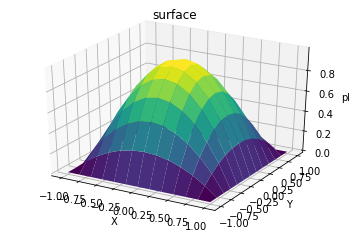

In [10]:
ax  = plt.axes(projection='3d')

ax.plot_surface(X, Y, phi, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

ax.set_title('surface');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('phi')

plt.show()

### Q: Compare the number of iterations needed to the iterative methods of the previous lecture.

Here below are two tables :
- the first one compares how fast SOR, Gauss-Seidel (GS) & multi-Grid method (GS enhancement) methods do converge for a given error $\epsilon = 10^{-6}$
- the second one compares times took by these methods to reach same error $\epsilon = 10^{-6}$

In [11]:
import pandas as pd

# Table 1
data1 = [[200, 39, 4], [803, 123, 10], [3217, 551, 12], [12872, 2255, 18]]
print('ITERATIONS')
pd.DataFrame(data1, index=["13x13", "25x25", "49x49", "97x97"], columns=["Jacobi", "Gauss-Seidel", "SOR"])

ITERATIONS


,Jacobi,Gauss-Seidel,SOR
13x13,200,39,4
25x25,803,123,10
49x49,3217,551,12
97x97,12872,2255,18


In [12]:
# Table 2
data2 = [[0.055, 0.016, 0.06], [0.81, 0.2, 0.33], [13.4, 3.4, 2.7], [211, 57.6, 16.5]]
print("TIME CALCULATION")
pd.DataFrame(data2, index=["13x13", "25x25", "49x49", "97x97"], columns=["Gauss-Seidel", "SOR", "Multi-Grids"])

TIME CALCULATION


,Gauss-Seidel,SOR,Multi-Grids
13x13,0.055,0.016,0.06
25x25,0.810,0.200,0.33
49x49,13.400,3.400,2.70
97x97,211.000,57.600,16.50


Note that the results from multigrids method are very dependent on the number of multi grids one considers.

A point to consider then with multi-grids method is that one could increase the number of multi-grid method, which would result into the method being much more efficient than previous one.

However, if doing so the method gets much longer, and we thus have to do a compromise between aimed precision and calculation time.

To conclude, multi-grids method is more efficient, but limited in term of time caclulation when comparing to previous methods. As well, similar process can be implemented as the W cycle or as well the full multigrid cycle (FMC) mehod in order to compensate that and perhaps be able to run more precise calculations (i.e. lowe number of iteration to get to the result) while reducing calculation time.